In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn import metrics

from mlxtend.frequent_patterns import apriori, association_rules

/var/folders/7t/860dclk54774ltwycrvfp7nc0000gn/T/ipykernel_40322/1330362305.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("../dataset/df_rescaled.csv")

In [3]:
def prepare_for_apriori(df, n_bins=4):
    boolean_df = pd.DataFrame(index=df.index)

    for col in df.columns:
        if pd.api.types.is_bool_dtype(df[col]):
            # Mantieni le colonne booleane così come sono
            boolean_df[col] = df[col]

        elif pd.api.types.is_numeric_dtype(df[col]):
            # Binning su variabili numeriche
            bins = np.histogram_bin_edges(df[col].dropna(), bins=n_bins)
            binned = pd.cut(df[col], bins=bins, include_lowest=True)
            dummies = pd.get_dummies(binned, prefix=col)
            boolean_df = pd.concat([boolean_df, dummies.astype(bool)], axis=1)

    return boolean_df

In [4]:
df_pm = prepare_for_apriori(df, n_bins=4)

In [5]:
df_pm.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure_(-0.001, 0.25]',
       'tenure_(0.25, 0.5]', 'tenure_(0.5, 0.75]', 'tenure_(0.75, 1.0]',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges_(-0.001, 0.25]',
       'MonthlyCharges_(0.25, 0.5]', 'MonthlyCharges_(0.5, 0.75]',
       'MonthlyCharges_(0.75, 1.0]', 'TotalCharges_(-0.001, 0.25]',
       'TotalCharges_(0.25, 0.5]', 'TotalCharges_(0.5, 0.75]',
       'TotalCharges_(0.75, 1.0]', 'Churn', 'IsMale',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No'],
      dtype='object')

# Frequent Itemset

In [6]:
frequent_itemsets = apriori(df_pm, min_support=0.05, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.162767,(SeniorCitizen)
1,0.484023,(Partner)
2,0.299429,(Dependents)
3,0.385307,"(tenure_(-0.001, 0.25])"
4,0.186591,"(tenure_(0.25, 0.5])"
...,...,...
7470,0.054066,"(IsMale, StreamingTV, InternetService_Fiber op..."
7471,0.055350,"(StreamingTV, InternetService_Fiber optic, Pap..."
7472,0.055635,"(StreamingTV, InternetService_Fiber optic, Pap..."
7473,0.054779,"(StreamingTV, DeviceProtection, InternetServic..."


# Association Rules

In [7]:
frequent_itemsets = apriori(df_pm, min_support=0.03, use_colnames=True)
res = association_rules(frequent_itemsets, metric="lift", min_threshold=0.75)
#export to dataframe
res1= res[['antecedents','consequents','support','confidence','lift']]
#cut at lift threshold
res2 = res1[res1['lift']>2.1]
#sort
df2=res2.sort_values(by =['lift'],ascending=(False),ignore_index=True )
#reindex
df2.index=df2.index+1
df2

,antecedents,consequents,support,confidence,lift
1,"(tenure_(-0.001, 0.25], MonthlyCharges_(0.75, ...","(TotalCharges_(-0.001, 0.25], StreamingTV, Str...",0.030528,0.884298,20.191940
2,"(TotalCharges_(-0.001, 0.25], StreamingTV, Str...","(MonthlyCharges_(0.75, 1.0], tenure_(-0.001, 0...",0.030528,0.697068,20.191940
3,"(tenure_(-0.001, 0.25], MonthlyCharges_(0.75, ...","(StreamingTV, InternetService_Fiber optic, Pho...",0.030528,0.884298,20.191940
4,"(TotalCharges_(-0.001, 0.25], StreamingTV, Str...","(tenure_(-0.001, 0.25], MonthlyCharges_(0.75, ...",0.030528,0.697068,20.191940
5,"(StreamingTV, InternetService_Fiber optic, Pho...","(tenure_(-0.001, 0.25], MonthlyCharges_(0.75, ...",0.030528,0.697068,20.191940
...,...,...,...,...,...
856834,"(StreamingTV, tenure_(0.75, 1.0], PaperlessBil...",(OnlineBackup),0.058345,0.726465,2.100009
856835,"(DeviceProtection, TechSupport, PhoneService)","(IsMale, Partner, StreamingTV)",0.034522,0.232469,2.100008
856836,"(IsMale, Partner, StreamingTV)","(DeviceProtection, TechSupport, PhoneService)",0.034522,0.311856,2.100008
856837,"(PhoneService, PaymentMethod_Electronic check,...","(PaperlessBilling, SeniorCitizen)",0.036234,0.262126,2.100003


In [8]:
#select all the rules where the consequnts is (Churn)
df2[df2['consequents'].apply(lambda x: 'Churn' in x)]
#select all the rules where the consequnts is (Churn) only
df2_churn = df2[df2['consequents'].apply(lambda x: 'Churn' in x) & df2['consequents'].apply(lambda x: len(x)==1)]

#reindex


In [9]:
df2_churn

,antecedents,consequents,support,confidence,lift
569271,"(InternetService_Fiber optic, PaperlessBilling...",(Churn),0.031954,0.767123,2.895818
569273,"(InternetService_Fiber optic, PaperlessBilling...",(Churn),0.031954,0.767123,2.895818
569276,"(InternetService_Fiber optic, PaperlessBilling...",(Churn),0.031954,0.767123,2.895818
569278,"(InternetService_Fiber optic, PaperlessBilling...",(Churn),0.031954,0.767123,2.895818
571881,"(InternetService_Fiber optic, PaperlessBilling...",(Churn),0.031954,0.764505,2.885935
...,...,...,...,...,...
856216,"(PaperlessBilling, MonthlyCharges_(0.5, 0.75],...",(Churn),0.031526,0.556675,2.101396
856506,"(Contract_Month-to-month, PaperlessBilling, Mo...",(Churn),0.047076,0.556492,2.100706
856507,"(PaperlessBilling, MonthlyCharges_(0.75, 1.0],...",(Churn),0.047076,0.556492,2.100706
856509,"(InternetService_Fiber optic, PaperlessBilling...",(Churn),0.047076,0.556492,2.100706


In [10]:
#print the most significant rules in terms of lift
df2_churn.iloc[0:5,:]
#print formatted output
for i in range(0,5):
    print("Rule: ",df2_churn.iloc[i,0], " -> ",df2_churn.iloc[i,1])
    print("Support: ",df2_churn.iloc[i,2])
    print("Confidence: ",df2_churn.iloc[i,3])
    print("Lift: ",df2_churn.iloc[i,4])
    print("\n")

Rule:  frozenset({'InternetService_Fiber optic', 'PaperlessBilling', 'Contract_Month-to-month', 'MultipleLines', 'tenure_(-0.001, 0.25]', 'PaymentMethod_Electronic check', 'TotalCharges_(-0.001, 0.25]'})  ->  frozenset({'Churn'})
Support:  0.03195435092724679
Confidence:  0.767123287671233
Lift:  2.8958181187804755


Rule:  frozenset({'InternetService_Fiber optic', 'PaperlessBilling', 'Contract_Month-to-month', 'MultipleLines', 'tenure_(-0.001, 0.25]', 'PhoneService', 'PaymentMethod_Electronic check', 'TotalCharges_(-0.001, 0.25]'})  ->  frozenset({'Churn'})
Support:  0.03195435092724679
Confidence:  0.767123287671233
Lift:  2.8958181187804755


Rule:  frozenset({'InternetService_Fiber optic', 'PaperlessBilling', 'Contract_Month-to-month', 'MultipleLines', 'tenure_(-0.001, 0.25]', 'PaymentMethod_Electronic check'})  ->  frozenset({'Churn'})
Support:  0.03195435092724679
Confidence:  0.767123287671233
Lift:  2.8958181187804755


Rule:  frozenset({'InternetService_Fiber optic', 'Paperles

In [11]:
# print the most significant rules in terms of confidence
#order by confidence
df2_churn = df2_churn.sort_values(by =['confidence'],ascending=(False),ignore_index=True )


df2_churn.iloc[0:5,:]
#print formatted output
for i in range(0,5):
    print("Rule: ",df2_churn.iloc[i,0], " -> ",df2_churn.iloc[i,1])
    print("Support: ",df2_churn.iloc[i,2])
    print("Confidence: ",df2_churn.iloc[i,3])
    print("Lift: ",df2_churn.iloc[i,4])
    print("\n")

Rule:  frozenset({'InternetService_Fiber optic', 'PaperlessBilling', 'Contract_Month-to-month', 'MultipleLines', 'tenure_(-0.001, 0.25]', 'PaymentMethod_Electronic check', 'TotalCharges_(-0.001, 0.25]'})  ->  frozenset({'Churn'})
Support:  0.03195435092724679
Confidence:  0.767123287671233
Lift:  2.8958181187804755


Rule:  frozenset({'InternetService_Fiber optic', 'PaperlessBilling', 'Contract_Month-to-month', 'MultipleLines', 'tenure_(-0.001, 0.25]', 'PhoneService', 'PaymentMethod_Electronic check'})  ->  frozenset({'Churn'})
Support:  0.03195435092724679
Confidence:  0.767123287671233
Lift:  2.8958181187804755


Rule:  frozenset({'InternetService_Fiber optic', 'PaperlessBilling', 'Contract_Month-to-month', 'MultipleLines', 'tenure_(-0.001, 0.25]', 'PhoneService', 'PaymentMethod_Electronic check', 'TotalCharges_(-0.001, 0.25]'})  ->  frozenset({'Churn'})
Support:  0.03195435092724679
Confidence:  0.767123287671233
Lift:  2.8958181187804755


Rule:  frozenset({'InternetService_Fiber o

In [12]:
# print the most significant rules in terms of support
#order by support
df2_churn = df2_churn.sort_values(by =['support'],ascending=(False),ignore_index=True )
df2_churn.iloc[0:5,:]
#print formatted output
for i in range(0,5):
    print("Rule: ",df2_churn.iloc[i,0], " -> ",df2_churn.iloc[i,1])
    print("Support: ",df2_churn.iloc[i,2])
    print("Confidence: ",df2_churn.iloc[i,3])
    print("Lift: ",df2_churn.iloc[i,4])
    print("\n")

Rule:  frozenset({'Contract_Month-to-month', 'PaperlessBilling', 'InternetService_Fiber optic'})  ->  frozenset({'Churn'})
Support:  0.13637660485021397
Confidence:  0.5680332739156267
Lift:  2.1442720787014236


Rule:  frozenset({'PaperlessBilling', 'Contract_Month-to-month', 'PhoneService', 'InternetService_Fiber optic'})  ->  frozenset({'Churn'})
Support:  0.13637660485021397
Confidence:  0.5680332739156267
Lift:  2.1442720787014236


Rule:  frozenset({'Contract_Month-to-month', 'tenure_(-0.001, 0.25]', 'PaperlessBilling'})  ->  frozenset({'Churn'})
Support:  0.12253922967189729
Confidence:  0.5703851261620185
Lift:  2.1531500992976578


Rule:  frozenset({'PaperlessBilling', 'TotalCharges_(-0.001, 0.25]', 'Contract_Month-to-month', 'tenure_(-0.001, 0.25]'})  ->  frozenset({'Churn'})
Support:  0.12253922967189729
Confidence:  0.5703851261620185
Lift:  2.1531500992976578


Rule:  frozenset({'InternetService_Fiber optic', 'TotalCharges_(-0.001, 0.25]'})  ->  frozenset({'Churn'})
Suppor

# pyfim

In [13]:
from fim import apriori

In [14]:
X = df_pm.copy()

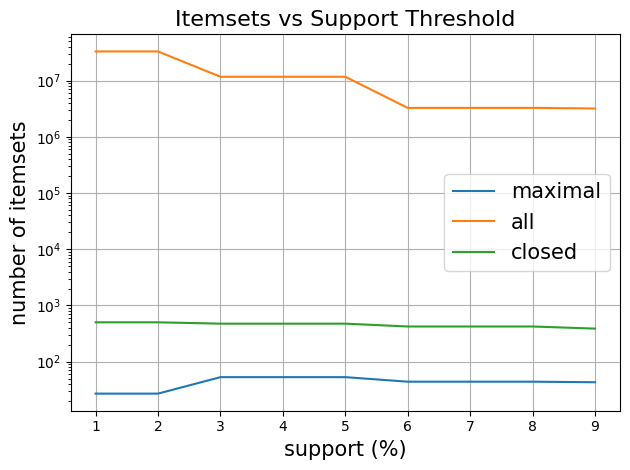

In [15]:
# Lista dei supporti in percentuale
supports = list(range(1, 50))  # 1% to 50%

len_max_it = []
len_cl_it = []
len_all_it = []

for supp in supports:
    max_itemsets = apriori(X, target='m', supp=supp, zmin=1)
    cl_itemsets = apriori(X, target='c', supp=supp, zmin=1)
    all_itemsets = apriori(X, target='s', supp=supp, zmin=1)
    
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))
    len_all_it.append(len(all_itemsets))

# Plot
plt.plot(supports, len_max_it, label='maximal')
plt.plot(supports, len_all_it, label='all')
plt.plot(supports, len_cl_it, label='closed')

plt.legend(fontsize=15)
plt.xlabel('support (%)', fontsize=15)
plt.ylabel('number of itemsets', fontsize=15)
plt.title('Itemsets vs Support Threshold', fontsize=16)
plt.grid(True)
#logarithmic scale
plt.yscale('log')
plt.tight_layout()
plt.show()


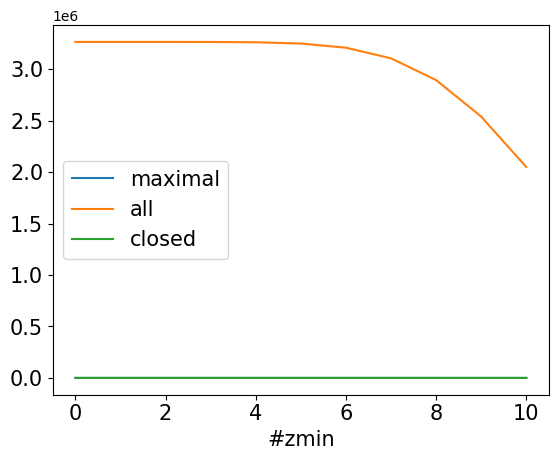

In [16]:
len_max_it = []
len_cl_it = []
len_all_it = []
for i in range(0, 10+1):
    max_itemsets = apriori(X, target='m', supp=6, zmin=i)
    cl_itemsets = apriori(X, target='c', supp=6, zmin=i)
    len_max_it.append( len(max_itemsets)  )
    len_cl_it.append( len(cl_itemsets) )

for i in range(0, 10+1):
    all_itemsets = apriori(X, target='s', supp=6, zmin=i)
    len_all_it.append( len(all_itemsets) )


plt.plot(len_max_it, label='maximal')
plt.plot(len_all_it, label='all')
plt.plot(len_cl_it, label='closed')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('#zmin', fontsize=15)

plt.show()

In [17]:

df_pm["Churn_True"] = df["Churn"] == True  # o == 1 a seconda dei tuoi dati

def df_to_transactions(df_bool):
    return [
        df_bool.columns[row].tolist()
        for _, row in df_bool.iterrows()
    ]

transactions = df_to_transactions(df_pm)

# 3. Estrai regole di associazione con Apriori
rules = apriori(
    transactions,
    target='r',        # regole
    supp=1,            # supporto minimo in %
    conf=90,           # confidence minima in %
    report='scul',     # s: support, c: conf, u: length, l: lift
    zmin=2             # almeno 2 item (antecedente + conseguente)
)

# 4. Filtra regole con Churn_True come conseguente
rules_churn = [r for r in rules if 'Churn_True' in r[1]]

# 5. Ordina per lift decrescente
rules_churn_sorted = sorted(rules_churn, key=lambda r: r[4], reverse=True)

# 6. Stampa le prime 10 regole più interessanti
print("\nTop regole che implicano Churn=True:\n")
for antecedent, consequent, supp, conf, length, lift in rules_churn_sorted[:10]:
    print(f"{antecedent} => {consequent} (support: {supp:.1f}%, confidence: {conf:.1f}%, lift: {lift:.2f})")



Top regole che implicano Churn=True:

PhoneService => ('InternetService_No', 'MonthlyCharges_(-0.001, 0.25]', 'Churn_True', 'Churn', 'tenure_(-0.001, 0.25]', 'Contract_Month-to-month', 'TotalCharges_(-0.001, 0.25]') (support: 0.0%, confidence: 1.0%, lift: 1.11)
TotalCharges_(-0.001, 0.25] => ('InternetService_No', 'MonthlyCharges_(-0.001, 0.25]', 'Churn_True', 'Churn', 'tenure_(-0.001, 0.25]', 'Contract_Month-to-month', 'PhoneService') (support: 0.0%, confidence: 1.0%, lift: 1.64)
Contract_Month-to-month => ('InternetService_No', 'MonthlyCharges_(-0.001, 0.25]', 'Churn_True', 'Churn', 'tenure_(-0.001, 0.25]', 'TotalCharges_(-0.001, 0.25]', 'PhoneService') (support: 0.0%, confidence: 0.9%, lift: 1.72)
tenure_(-0.001, 0.25] => ('InternetService_No', 'MonthlyCharges_(-0.001, 0.25]', 'Churn_True', 'Churn', 'Contract_Month-to-month', 'TotalCharges_(-0.001, 0.25]', 'PhoneService') (support: 0.0%, confidence: 1.0%, lift: 2.49)
Churn => ('InternetService_No', 'MonthlyCharges_(-0.001, 0.25]', 

In [18]:
rules = apriori(X, target='r', supp=6.5, zmin=3, conf=75, report='aScl')
len(rules)
#export to dataframe
df4 = pd.DataFrame(rules, columns=['target','antecedent','supp','supp (%)','conf','lift'])
columns_titles = ['antecedent','target','lift','conf','supp (%)','supp']
#reindex columns for better reading
df4=df4.reindex(columns=columns_titles)
#cut at thresholds
df4=df4.loc[df4['lift']>1.6]
df4=df4.loc[df4['supp (%)']>6.5]
#sorting
df4=df4.sort_values(by =['target','lift'],ascending=False,ignore_index=True )
#reindex rows
df4.index=df4.index+1
df4

,antecedent,target,lift,conf,supp (%),supp
1,"(k, d, m, P, c, M, i, h, a, , o, _, n, t, e)",y,3.272727,1.000000,8.333333,3
2,"(k, d, m, P, c, M, i, h, a, , o, _, n, t)",y,3.272727,1.000000,8.333333,3
3,"(k, d, m, P, c, M, i, h, a, , o, _, n, e)",y,3.272727,1.000000,8.333333,3
4,"(k, d, m, P, c, M, i, h, a, , o, _, n)",y,3.272727,1.000000,8.333333,3
5,"(k, d, m, P, c, M, i, h, a, , o, _, t, e)",y,3.272727,1.000000,8.333333,3
...,...,...,...,...,...,...
25740565,"(h, o, r, e)",,1.603239,0.846154,30.555556,11
25740566,"(h, r, t)",,1.603239,0.846154,30.555556,11
25740567,"(h, r, e)",,1.603239,0.846154,30.555556,11
25740568,"(o, _, n, t)",,1.603239,0.846154,30.555556,11
